# Axis to Regression Registration Pilot Rigid Registration Pipeline

## Data loading

In [1]:
# auto reload packages installed with -e when they change before running the cell
# this is useful for development so you don't have to restart the kernel each time
# you make a change to the pkg code
%load_ext autoreload
%autoreload 2

from sidus import io, plotting as pl
import pandas as pd
import ants
from wsifir.utils import get_affine_matrix_from_ants
from wsifir.metrics import compute_metrics
from wsifir.utils import ants_from_sdata
from wsifir import plotting as wpl
from wsifir.utils import get_affine_table


### Load clinical data

In [2]:
#Load the axis,regression and tbet clinical data
ids = pd.read_csv('C:/Users/molanre1/Desktop/WSIFIR/ids.csv')
results = ids.iloc[0].to_dict()
results

{'axis_sampleid': 101,
 'reg_sampleid': 709,
 'tbet_sampleid': 834,
 'axis_slideid': 'L1_2',
 'reg_slideid': 'LY1',
 'tbet_slideid': 'AP0140001'}

In [3]:
image_id_reg = f"sampleid_{results['reg_sampleid']}_image"
reg_path = "//bki-fs1/data02/Clinical_Specimen_10"
image_id_axis = f"sampleid_{results['axis_sampleid']}_image"
axis_path = "//bki-fs1/data02/Clinical_Specimen_2"
#
# latest sidus version sets other elements to false by default
#
reg_image = io.load_astropath(
    sampleid=results['reg_sampleid'], sample_path=f"{reg_path}/{results['reg_slideid']}"
)
axis_image = io.load_astropath(
    sampleid=results['axis_sampleid'], sample_path=f"{axis_path}/{results['axis_slideid']}"
)

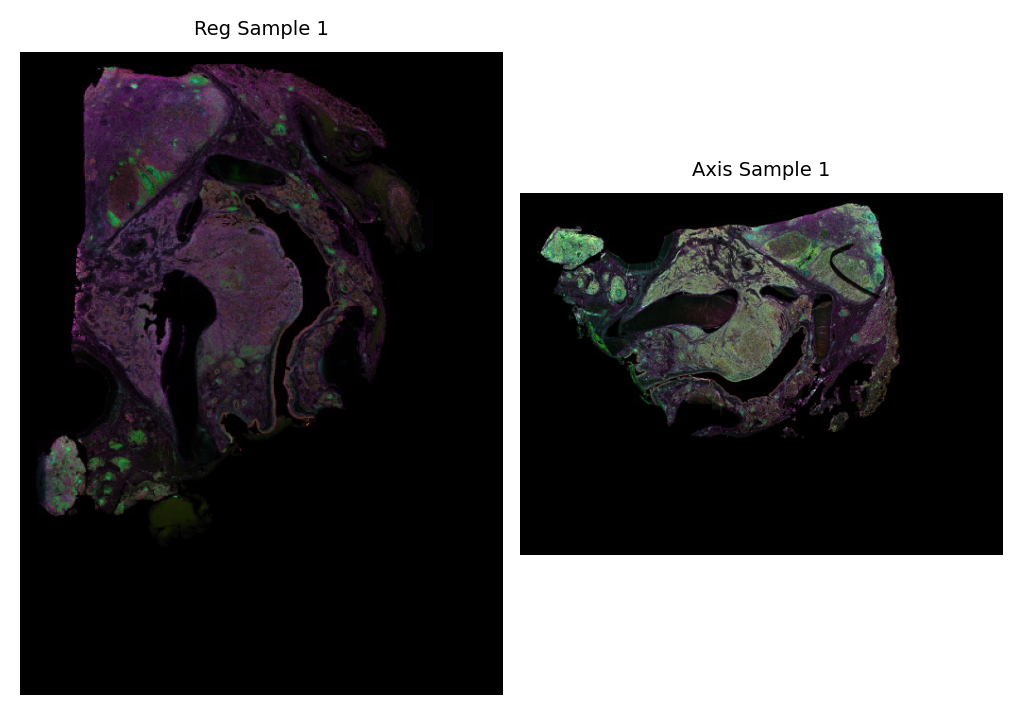

In [4]:

pl.SubPlots(
    pl.ShowImage(sdata=reg_image, sampleid=results['reg_sampleid'], title="Reg Sample 1"),  # reg_sampleid
    pl.ShowImage(sdata=axis_image, sampleid=results['axis_sampleid'], title="Axis Sample 1"),  # axis_sampleid
    figsize=(5, 5),
)


## Rigid Registration (Scale 9)

### Load in spatial data 

In [5]:
reg_image[image_id_reg]['scale9'].image[0]

<xarray.DataArray 'image' (y: 128, x: 96)> Size: 49kB
dask.array<getitem, shape=(128, 96), dtype=float32, chunksize=(128, 96), chunktype=numpy.ndarray>
Coordinates:
    c        int32 4B 0
  * y        (y) float64 1kB 256.0 768.0 1.28e+03 ... 6.477e+04 6.528e+04
  * x        (x) float64 768B 256.0 768.0 1.28e+03 ... 4.838e+04 4.89e+04
Attributes:
    transform:  {'global': Sequence \n    Scale (x, y)\n        [512. 512.]\n...

### Pad images

### ANTS Rigid transform 

In [ ]:
reg_ants_scale9 = ants_from_sdata(reg_image[image_id_reg], 'scale9')
axis_ants_scale9 = ants_from_sdata(axis_image[image_id_axis], 'scale9')

In [9]:
# see what it looks like for rigid
registered_image_a = ants.registration(
    fixed=reg_ants_scale9, moving=axis_ants_scale9, type_of_transform='Rigid', 
)
# 0,1 and 1,0 should be zero for rigid
# 0,0 and 1,1 are the rotation and 0,2 # and 2,0 are the translation
rigid_affine = get_affine_matrix_from_ants(registered_image_a['invtransforms'][0])  
rigid_affine

array([[ 9.99999583e-01,  9.02395754e-04,  2.39042334e+01],
       [-9.02395754e-04,  9.99999583e-01, -1.00593367e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [10]:
# rigid with initializer
affine_init_a = ants.affine_initializer(reg_ants_scale9, axis_ants_scale9, radian_fraction=0.5)
registered_image_a = ants.registration(
    fixed=reg_ants_scale9, moving=axis_ants_scale9, type_of_transform='Rigid', initial_transform=affine_init_a
)
# see how the affine 0,1 and 1,0 are more non-zero now.
# this indicates an affine transform was applied
get_affine_matrix_from_ants(registered_image_a['fwdtransforms'][0]) 

array([[  0.25711387,  -0.96225989,  93.49568968],
       [  0.96263796,   0.25379926, -15.12171538],
       [  0.        ,   0.        ,   1.        ]])

In [11]:
# here is the affine transform alone (very similar to above)
get_affine_matrix_from_ants(affine_init_a)

array([[  0.34003046,  -0.93617892,  88.79742065],
       [  0.93684453,   0.33676142, -18.69933139],
       [  0.        ,   0.        ,   1.        ]])

In [12]:
# this means that there is now no reason to do a rigid registration
# after an affine initializer, so let's skip that step
# and do an affine initializer followed by an affine registration
#
affine_init = ants.affine_initializer(
    reg_ants_scale9, axis_ants_scale9, radian_fraction=0.5
)
# Perform registration
registered_image = ants.registration(
    fixed=reg_ants_scale9, moving=axis_ants_scale9, initial_transform=affine_init,
    type_of_transform='Affine',
    aff_metric='MI',  # Mutual Information for same modality often still works best on histo data
    aff_sampling=32,  # Denser sampling than default (e.g., 32 voxels)
    aff_random_sampling_rate=0.25,  # Good for balancing cost/speed
    reg_iterations=(40, 20, 0),  # One resolution: coarser iterations only   
    verbose=False,
)
affine_matrix = get_affine_matrix_from_ants(registered_image['fwdtransforms'][0]) 
affine_matrix

array([[ 0.21497652, -0.97427845, 94.73357638],
       [ 0.86217445,  0.21236575, -9.47761509],
       [ 0.        ,  0.        ,  1.        ]])

(<Figure size 640x480 with 1 Axes>, <Axes: >)

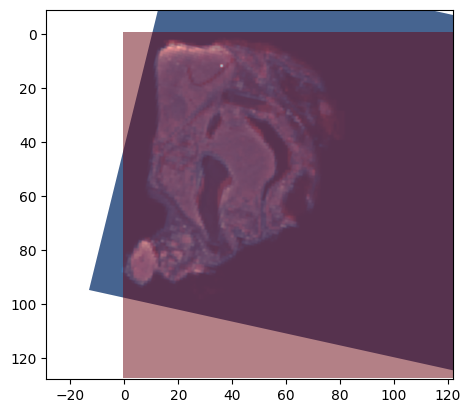

In [58]:
wpl.plot_transformation_mpl(reg_ants_scale9, axis_ants_scale9, affine_matrix)


In [14]:
#
# actually transforming the image as below is computationally expensive with large images
# the code above lets matplotlib adjust the image coordinates
#
transformed_image = ants.apply_transforms(
    fixed=reg_ants_scale9, moving=axis_ants_scale9, transformlist=registered_image['fwdtransforms']
)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

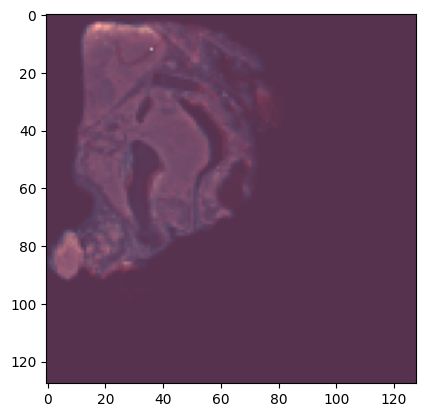

In [59]:
wpl.plot_transformed_image(reg_ants_scale9, transformed_image)

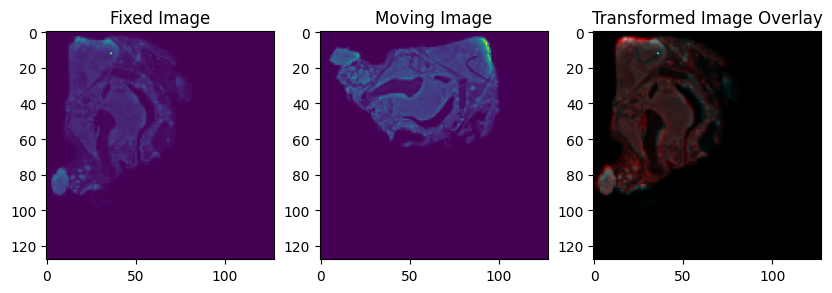

In [60]:
fig, axes = wpl.plot_transformation_panels(reg_ants_scale9, axis_ants_scale9, transformed_image, figsize=(10, 5))

### Metrics

In [56]:
metrics = []
metrics.append(
    compute_metrics(results['reg_sampleid'], results['axis_sampleid'], 'original', reg_ants_scale9, axis_ants_scale9)
)
metrics.append(
    compute_metrics(results['reg_sampleid'], results['axis_sampleid'], 9, reg_ants_scale9, transformed_image)
)
merged_df = pd.concat(metrics)
merged_df.head()

,fixed_image_id,moving_image_id,scale_name,Mutual Information,Cross Correlation,Mean Squared Error,Jaccard Index,F1 Score,Hausdorff Distance
0,709,101,original,-0.060823,-0.066338,4.255234,0.648649,0.774323,44.407207
0,709,101,9,-0.411916,-0.724641,1.619103,0.902948,0.948328,10.440307


In [70]:
get_affine_table(results['reg_sampleid'], results['axis_sampleid'], '9', affine_matrix)


,fixed_image_id,moving_image_id,scale,a,b,tx,c,d,ty
0,709,101,9,0.214977,-0.974278,94.733576,0.862174,0.212366,-9.477615
